**Step 1: Import packages**

In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import kerastuner as kt

import IPython

# sklearn libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# sklearn libraries for models
from sklearn.linear_model import LogisticRegression

# sklearn libraries for evaluation
from sklearn import metrics


from tensorflow import keras
from kerastuner import HyperModel
from kerastuner import RandomSearch, Hyperband


**Step 2: Define working directories**

In [2]:
#os.chdir('C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project')
os.chdir('/Users/alyssaaugsburger/Documents/Berkeley_MIDS/W207/Final_Project')

**Step 3: Define classes**

**Step 4: Define functions**

In [3]:
def reduce(X, n):
    '''PCA dimensionality reduction for X array and n principal components'''
    pca = PCA(n_components = n) 
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [4]:
def data_split(X, y, test_p, mini_s):
    '''Split train and test data for X,y data arrays with test_p percentage of observations in the test data and 
    mini_s number of observations in the mini_train set.'''
    # Split into train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=test_p, random_state=1, stratify=y)

    # Split test data into development data and training into mini train set for computation time
    dev_data, dev_labels = test_data[:int(test_data.shape[0]*0.5)], test_labels[:int(test_data.shape[0]*0.5)]
    mini_train_data, mini_train_labels = train_data[:mini_s], train_labels[:mini_s]
    print('Train data shape:', train_data.shape)
    print('Dev data shape:', dev_data.shape)
    print('Mini_train data shape:', mini_train_data.shape)
    
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels

In [5]:
def log_reg(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        LR.append(round(metrics.f1_score(dev_Y, clf_pred, average='weighted'),3))

    return LR, c_values

In [6]:
def LR_accuracy_c(train_X, train_Y, dev_X, dev_Y):
    '''Calls logistic regression function and returns highest accuracy for specific value of C.'''
    accuracy_list = log_reg(train_X, train_Y, dev_X, dev_Y)[0]
    accuracy = [y for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    accuracy_index = [x for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    C = log_reg(train_X, train_Y, dev_X, dev_Y)[1][accuracy_index[0]]
    
    return accuracy[0], C

**Step 5: Read data**

5.1 Load and combine pixel data files into dataframe

In [7]:
# Load npz files to combine and print content files
data_1 = np.load('et_w207_project_npz_files_5000_tmp_tmp5ocrhjnn.npz')
data_1.close

data_2 = np.load('et_w207_project_npz_files_5000_tmp_tmp092sag67.npz')
data_2.close

data_3 = np.load('et_w207_project_npz_files_5000_tmp_tmpf31_pn8p.npz')
data_3.close

data_4 = np.load('et_w207_project_npz_files_5000_tmp_tmpq5b2g4n2.npz')
data_4.close

print(data_1.files)

['arr_0', 'arr_1']


In [8]:
# Show file arr_0 example
data_1['arr_0'][:5]

array(['ozbpir-9ey6js-ggdqwo', '378ykanq', 'p366md-big834-7o23k6',
       '3zruwvl2', 'q18iae-3vnh74-79npmy'], dtype='<U20')

In [9]:
# Show file arr_1 example
data_1['arr_1'][:5]

array([[-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ],
       [ -46.939003,  -74.779   , -118.68    , ...,  -57.939003,
         -84.779   , -118.68    ],
       [ 151.061   ,  138.22101 ,  131.32    , ...,  151.061   ,
         138.22101 ,  131.32    ],
       [  -3.939003,  -66.779   ,  -96.68    , ...,   -3.939003,
         -66.779   ,  -96.68    ],
       [-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ]], dtype=float32)

In [10]:
# Get number of observations in each file
print(data_1['arr_0'].shape)
print(data_2['arr_0'].shape)
print(data_3['arr_0'].shape)
print(data_4['arr_0'].shape)

(878,)
(893,)
(638,)
(1353,)


In [11]:
# Concatenate data from all files
data_key = np.concatenate((data_1['arr_0'], data_2['arr_0'], data_3['arr_0'], data_4['arr_0']))

data_pixel = np.concatenate((data_1['arr_1'], data_2['arr_1'], data_3['arr_1'], data_4['arr_1']))
print(data_pixel.shape)

(3762, 150528)


In [12]:
# Create key value pairs with attachment key and pixel array
# Standardize pixel values between 0 and 1 by dividing by 255
# Store pixel data as dataframe
data_dict = {}
for i in range(data_key.shape[0]):
    data_dict[data_key[i]] = [data_pixel[i]/255]

df_pixel = pd.DataFrame(data=data_dict)
df_pixel_t = df_pixel.transpose()
df_pixel_t.index.names = ['attachment_key']
df_pixel_t.columns = ['pixel_array']
df_pixel_t

,pixel_array
attachment_key,
ozbpir-9ey6js-ggdqwo,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
378ykanq,"[-0.18407452, -0.29325098, -0.46541175, -0.097..."
p366md-big834-7o23k6,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3zruwvl2,"[-0.015447071, -0.26187843, -0.37913725, -0.01..."
q18iae-3vnh74-79npmy,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
...,...
pktyig-481wyg-6gyulf,"[-0.3605451, -0.41089803, -0.38305882, -0.3644..."
zu7y3rha,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
pxcwxf-8tnpyg-8vhb9r,"[0.3022, 0.18125883, 0.12674509, 0.31004313, 0..."


5.2 Load metadata file

In [13]:
# Load excel data
#df = pd.read_csv('school_project_data_set-new.csv')
df = pd.read_csv('school_project_data_set-query.csv')
df.head()

,attachment_key,size_mb,height,width,h_to_w,filename,logo
0,001lq61k,0.122520,514.0,720.0,0.713889,campus ministry on the beach.jpg,0
1,002dlirq,3.256944,4072.0,3868.0,1.052741,BIG ALS FISH FLASH UV VP PL.jpg,0
2,003qefgm,0.002522,80.0,200.0,0.400000,netix_email_studio.png,1
3,0083okjl,0.116802,600.0,600.0,1.000000,productshot2.jpg,0
4,00a957mh,0.140714,816.0,2382.0,0.342569,divine_medical_billing_inc_master.png,1


5.3 Combine pixel and metadata features in a pandas dataframe

In [14]:
# Merge dataframes by attachment key
combined_df = df.merge(df_pixel_t, on='attachment_key')
combined_df

,attachment_key,size_mb,height,width,h_to_w,filename,logo,pixel_array
0,00xjny6u,0.011849,520.0,506.0,1.027668,Esterdale Theatre - Logo.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
1,04o31jop,0.012610,269.0,396.0,0.679293,BLUE_LOGO.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
2,0840h7ox,0.399114,518.0,920.0,0.563044,ZEN_LB-5.jpg,0,"[0.106121555, 0.05576863, 0.052235294, 0.09043..."
3,0awudx2h,0.011226,200.0,200.0,1.000000,article central 200.jpg,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
4,0bb8y85h,0.263813,885.0,800.0,1.106250,1116-100_WGTank_white.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
...,...,...,...,...,...,...,...,...
3750,zu7y3rha,0.147371,498.0,702.0,0.709402,journalism.jpg,0,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
3751,zuanbsqe,0.580392,206.0,415.0,0.496386,2013 05 26_techstars_id_final_bug solo graysca...,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3752,zw9234v4,2.021135,1645.0,1450.0,1.134483,SPIN N GLO SILVER WING GPK MY.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3753,zxfqbfj1,0.012057,36.0,345.0,0.104348,cornerstone web logo medium.png,1,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."


In [15]:
### VISUALIZATIONS FROM PANDAS PROFILING HERE

**Step 6: Data preprocessing**

6.1 Remove null values

In [16]:
# Remove rows with null values
combined_df = combined_df[combined_df.height.notnull()]
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attachment_key  3754 non-null   object 
 1   size_mb         3754 non-null   float64
 2   height          3754 non-null   float64
 3   width           3754 non-null   float64
 4   h_to_w          3754 non-null   float64
 5   filename        3754 non-null   object 
 6   logo            3754 non-null   int64  
 7   pixel_array     3754 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 264.0+ KB


6.2 Create file type dummy variables from file name

In [17]:
# Find file types from filename
file_types = []
for item in combined_df['filename']:
    file_types.append(item[-3:].lower())

print(set(file_types))

{'lue', '73e', 'jpg', 'pig', 'jpe', '0mm', 'png', 'peg', 'hot', 'age', 'ack', 'ite'}


In [18]:
# Create list of file types from filename to append to df
filetype_encoding = []
for item in combined_df['filename']:
    if item[-3:].lower() == 'jpg':
        filetype_encoding.append('jpg')
    elif item[-3:].lower() == 'png':
        filetype_encoding.append('png')
    else:
        filetype_encoding.append('other')

In [19]:
# Create df that includes column for file type
combined_df['filetype'] = filetype_encoding
combined_df = combined_df[['attachment_key', 'size_mb', 'height', 'width', 'h_to_w', 'filetype', 'pixel_array', 'filename','logo']]
combined_df.head()
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

/Users/alyssaaugsburger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0


In [20]:
# Get dummies for file type
filetype_dummies = pd.get_dummies(combined_df.filetype)

# add to initial df
combined_df = pd.concat((combined_df, filetype_dummies), axis=1)

# print head of df
combined_df.head()

,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo,jpg,other,png
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1,0,0,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1,0,0,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0,1,0,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1,1,0,0
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0,1,0,0


6.3 Scale metadata variables

In [21]:
# Scale continuous feature variables
combined_df['size_mb'] = preprocessing.scale(combined_df['size_mb'])
combined_df['h_to_w'] = preprocessing.scale(combined_df['h_to_w'])
combined_df['height'] = preprocessing.scale(combined_df['height'])
combined_df['width'] = preprocessing.scale(combined_df['width'])

6.4 Create X, y arrays

In [22]:
# Organize df to separate into feature arrays
combined_df = combined_df[['attachment_key', 'pixel_array', 'size_mb', 'h_to_w', 'jpg', 'png', 'other',
                                     'height', 'width', 'logo', 'filetype', 'filename']]
combined_df.head()

,attachment_key,pixel_array,size_mb,h_to_w,jpg,png,other,height,width,logo,filetype,filename
0,00xjny6u,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366308,0.638439,0,1,0,-0.712708,-0.888611,1,png,Esterdale Theatre - Logo.png
1,04o31jop,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366187,-0.187892,0,1,0,-0.861519,-0.943446,1,png,BLUE_LOGO.png
2,0840h7ox,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",-0.304882,-0.463630,1,0,0,-0.713894,-0.682232,0,jpg,ZEN_LB-5.jpg
3,0awudx2h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366407,0.572811,1,0,0,-0.902427,-1.041152,1,jpg,article central 200.jpg
4,0bb8y85h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.326343,0.824832,1,0,0,-0.496310,-0.742052,0,jpg,1116-100_WGTank_white.jpg


In [23]:
# y array contains logo/not logo binary variable
y = np.array(combined_df.iloc[:, 9])

# X array contains pixel array only
X = np.array(combined_df['pixel_array'].tolist())
print(X.shape)

(3754, 150528)


6.5 Reduce dimensionality of pixel data

In [24]:
# Reduce dimensionality of pixel array
X_reduced = reduce(X,2)

In [25]:
### PCA VISUALIZATIONS HERE

6.6 Create alternate X arrays with metadata features

In [26]:
# Create variations of X array with reduced pixel data and different metadata features

# X2 array contains pixel features, size, height, width, h_to_w, filetype dummies
X2 = np.concatenate((X_reduced, np.array(combined_df.iloc[:, 2:9])),axis=1)
print(X2.shape)

# X3 array contains pixel features, size, h_to_w, filetype dummies
X3 = np.concatenate((X_reduced, np.array(combined_df.iloc[:, 2:7])),axis=1)
print(X3.shape)

# X4 array contains pixel array, size, h_to_w
X4 = np.concatenate((X_reduced, np.array(combined_df.iloc[:, 2:4])),axis=1)
print(X4.shape)

# X5 array contains pixel array, filetype dummies 
X5 = np.concatenate((X_reduced, np.array(combined_df.iloc[:, 4:7])),axis=1)
print(X5.shape)

# X6 array contains size, height, width, h_to_w, filetype
X6 = np.array(combined_df.iloc[:, 2:9])
print(X6.shape)

# X7 array contains size, h_to_w, filetype
X7 = np.array(combined_df.iloc[:, 2:7])
print(X7.shape)

(3754, 9)
(3754, 7)
(3754, 4)
(3754, 5)
(3754, 7)
(3754, 5)


6.7 Split each set of features into train, development, and test data

In [27]:
# Split all feature combinations into train, test data
train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels = data_split(X_reduced, y, 0.4, 100)
train_data2, train_labels2, test_data2, test_labels2, dev_data2, dev_labels2, mini_train_data2, mini_train_labels2 = data_split(X2, y, 0.4, 100)
train_data3, train_labels3, test_data3, test_labels3, dev_data3, dev_labels3, mini_train_data3, mini_train_labels3 = data_split(X3, y, 0.4, 100)
train_data4, train_labels4, test_data4, test_labels4, dev_data4, dev_labels4, mini_train_data4, mini_train_labels4 = data_split(X4, y, 0.4, 100)
train_data5, train_labels5, test_data5, test_labels5, dev_data5, dev_labels5, mini_train_data5, mini_train_labels5 = data_split(X5, y, 0.4, 100)
train_data6, train_labels6, test_data6, test_labels6, dev_data6, dev_labels6, mini_train_data6, mini_train_labels6 = data_split(X6, y, 0.4, 100)
train_data7, train_labels7, test_data7, test_labels7, dev_data7, dev_labels7, mini_train_data7, mini_train_labels7 = data_split(X7, y, 0.4, 100)

Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 9)
Dev data shape: (751, 9)
Mini_train data shape: (100, 9)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 4)
Dev data shape: (751, 4)
Mini_train data shape: (100, 4)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)


**Step 7: Logistic Regression**

7.1 Run logistic regression for pixel data only

In [28]:
# Pixel array only
# Run LR and output best accuracy with c value
print('Features: pixel features only\nBest Accuracy: {}, c={}'.format(
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[0],
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[1]))

Features: pixel features only
Best Accuracy: 0.577, c=0.001


7.2 Run logistic regression for all feature combinations

In [29]:
# Run LR and output best accuracies with c values for each combination of features
print('Features: pixel features, size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[0],
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[1]))

print('Features: pixel features, size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[0],
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[1]))

print('Features: pixel features, size, h_to_w\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[0],
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[1]))

print('Features: pixel features, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[0],
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[1]))

print('Features: size, height, width, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[0],
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[1]))

print('Features: size, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[0],
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[1]))

Features: pixel features, size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.858, c=0.1

Features: pixel features, size, h_to_w, filetype dummies
Best Accuracy: 0.849, c=2.0

Features: pixel features, size, h_to_w
Best Accuracy: 0.768, c=0.3

Features: pixel features, filetype dummies
Best Accuracy: 0.822, c=0.2

Features: size, height, width, h_to_w, filetype
Best Accuracy: 0.845, c=0.1

Features: size, h_to_w, filetype
Best Accuracy: 0.849, c=0.01



**Step 8: Multilayer NN**

In [182]:
# Function to build layers of neural net

def build_model(nodes, dropout_rate, lr):
    # Begins the linear arrangment of layers
    model = tf.keras.models.Sequential([

    # Creates a fully-connected layer. A layer is fully connected to the layer that preceds it.
    # Dense1_units number of nodes in the layer, choses a value between 1 and 100 based on optimization 
      tf.keras.layers.Dense(nodes, activation='relu'),

    # Uses dropout regularization by dropping 20% before next layer
      tf.keras.layers.Dropout(dropout_rate),

    # 2 nodes in final output for logo/not logo
      tf.keras.layers.Dense(2, activation='softmax') 
    ])
    
    model.compile(keras.optimizers.Adam(learning_rate = lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

# Other activation functions: activation='sigmoid'
# Other optimizers to try - Adam

In [167]:
def fit_model(model,data,labels,epoch_num):
    history = model.fit(data, labels, epochs = epoch_num)
    return history

In [98]:
def evaluate_model(model,data, labels):
    test_loss, test_acc = model.evaluate(data, labels)
    return test_acc

In [99]:
build_model_output = build_model(480,.5, .001)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 3.0338 - accuracy: 0.56 - ETA: 0s - loss: 2.8954 - accuracy: 0.60 - 0s 990us/step - loss: 2.7002 - accuracy: 0.6044
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.0865 - accuracy: 0.59 - ETA: 0s - loss: 1.9342 - accuracy: 0.63 - 0s 984us/step - loss: 1.8979 - accuracy: 0.6390
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 2.5818 - accuracy: 0.59 - ETA: 0s - loss: 1.5579 - accuracy: 0.66 - 0s 977us/step - loss: 1.4733 - accuracy: 0.6758
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 0.8600 - accuracy: 0.71 - ETA: 0s - loss: 1.0502 - accuracy: 0.71 - 0s 1ms/step - loss: 1.0388 - accuracy: 0.7158
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.78 - ETA: 0s - loss: 0.8135 - accuracy: 0.74 - 0s 988us/step - loss: 0.8108 - accuracy: 0.7349
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.5215 - accur

71/71 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.84 - ETA: 0s - loss: 0.3314 - accuracy: 0.84 - 0s 960us/step - loss: 0.3299 - accuracy: 0.8486
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.84 - ETA: 0s - loss: 0.3526 - accuracy: 0.84 - 0s 945us/step - loss: 0.3507 - accuracy: 0.8384
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.93 - ETA: 0s - loss: 0.3384 - accuracy: 0.84 - 0s 970us/step - loss: 0.3308 - accuracy: 0.8495
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.78 - ETA: 0s - loss: 0.3445 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3398 - accuracy: 0.8410
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.93 - ETA: 0s - loss: 0.3314 - accuracy: 0.84 - 0s 938us/step - loss: 0.3282 - accuracy: 0.8526
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0

### Hyperparameter Tuning

In [ ]:
#Try different optimizers
#Using #3 data - Adam is better than SGD

In [112]:
#Try different numbers of nodes - keep dropout at 50 and learning rate at .001

#Loop through nodes
final_accuracy_node_list = []

for i in range(1, 1000, 50):
    build_model_output = build_model(i, .5, .001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.53 - ETA: 0s - loss: 2.1731 - accuracy: 0.47 - 0s 769us/step - loss: 2.1568 - accuracy: 0.4742
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.1240 - accuracy: 0.43 - 0s 677us/step - loss: 1.2132 - accuracy: 0.4760
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.43 - 0s 648us/step - loss: 0.7029 - accuracy: 0.4827
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.40 - 0s 694us/step - loss: 0.6649 - accuracy: 0.5679
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.59 - 0s 635us/step - loss: 0.6507 - accuracy: 0.5686
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 16.2618 - accuracy: 0.468 - ETA: 0s - loss: 7.9478 - accuracy: 0.525 - 0s 880us/step - loss: 7.7687 - accuracy: 0.5315
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 1.8251 - accuracy: 0.68 - ETA: 0s - loss: 3.4102 - accuracy: 0.55 - 0s 991us/step - loss: 3.1901 - accuracy: 0.5755
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 3.1433 - accuracy: 0.65 - ETA: 0s - loss: 2.1490 - accuracy: 0.63 - 0s 947us/step - loss: 2.0998 - accuracy: 0.6314
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.2272 - accuracy: 0.71 - ETA: 0s - loss: 1.5855 - accuracy: 0.67 - 0s 1ms/step - loss: 1.5434 - accuracy: 0.6718
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 1.8647 - accuracy: 0.65 - ETA: 0s - loss: 1.2391 - accuracy: 0.71 - 0s 1ms/step - loss: 1.1634 - accuracy: 0.7145
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.90 - 0s 817us/step - loss: 0.4560 - accuracy: 0.8162
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 7.9851 - accuracy: 0.43 - ETA: 0s - loss: 3.1073 - accuracy: 0.6

24/24 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.84 - 0s 747us/step - loss: 0.4080 - accuracy: 0.8322
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 4.1361 - accuracy: 0.40 - ETA: 0s - loss: 2.4498 - accuracy: 0.60 - 0s 1ms/step - loss: 2.3496 - accuracy: 0.6079
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.78 - ETA: 0s - loss: 1.7478 - accuracy: 0.67 - 0s 1ms/step - loss: 1.7247 - accuracy: 0.6741
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.5516 - accuracy: 0.65 - ETA: 0s - loss: 1.2615 - accuracy: 0.70 - 0s 988us/step - loss: 1.2254 - accuracy: 0.7114
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 1.5282 - accuracy: 0.62 - ETA: 0s - loss: 1.0030 - accuracy: 0.71 - 0s 1ms/step - loss: 0.9629 - accuracy: 0.7256
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.90 - 0s 797us/step - loss: 0.4327 - accuracy: 0.8282
Ep

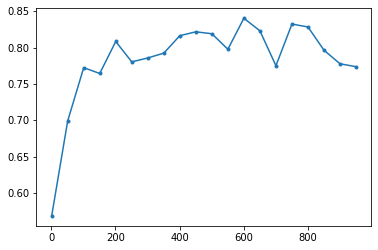

In [113]:
#Graph results
plt.plot(range(1,1000,50), final_accuracy_node_list, label = "Predicted Accuracies", marker = ".")

In [116]:
#It looks like best value is somewhere between 500 and 800
#Narrow this down
#Loop through nodes
final_accuracy_node_list = []

for i in range(500, 800, 25):
    build_model_output = build_model(i, .5, .001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 1.8745 - accuracy: 0.65 - ETA: 0s - loss: 2.8046 - accuracy: 0.58 - 0s 982us/step - loss: 2.6177 - accuracy: 0.5937
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 3.4272 - accuracy: 0.59 - ETA: 0s - loss: 1.9894 - accuracy: 0.63 - 0s 1ms/step - loss: 1.8788 - accuracy: 0.6479
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.7686 - accuracy: 0.71 - ETA: 0s - loss: 1.3665 - accuracy: 0.68 - 0s 960us/step - loss: 1.3376 - accuracy: 0.6785
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 2.2432 - accuracy: 0.50 - ETA: 0s - loss: 1.0731 - accuracy: 0.70 - 0s 1ms/step - loss: 1.0615 - accuracy: 0.7114
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.81 - 0s 747us/step - loss: 0.4944 - accuracy: 0.7870
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 5.7066 - accuracy: 0.53 - ETA: 0s - loss: 2.5598 - accuracy: 0.6

24/24 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.81 - 0s 834us/step - loss: 0.5190 - accuracy: 0.7790
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 5.1546 - accuracy: 0.50 - ETA: 0s - loss: 2.6606 - accuracy: 0.61 - 0s 1ms/step - loss: 2.5654 - accuracy: 0.6137
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 2.3035 - accuracy: 0.62 - ETA: 0s - loss: 1.7123 - accuracy: 0.66 - 0s 966us/step - loss: 1.6496 - accuracy: 0.6661
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 2.0464 - accuracy: 0.65 - ETA: 0s - loss: 1.2993 - accuracy: 0.69 - 0s 991us/step - loss: 1.2566 - accuracy: 0.6994
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 1.6591 - accuracy: 0.78 - ETA: 0s - loss: 1.0391 - accuracy: 0.72 - 0s 962us/step - loss: 1.0154 - accuracy: 0.7211
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.90 - 0s 888us/step - loss: 0.5351 - accuracy: 0.805

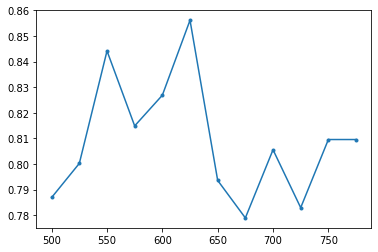

In [117]:
#Graph results
plt.plot(range(500,800,25), final_accuracy_node_list, label = "Predicted Accuracies", marker = ".")

In [118]:
#It looks like best value is somewhere between 625 and 650
#Narrow this down
#Loop through nodes
final_accuracy_node_list = []

for i in range(625, 650, 1):
    build_model_output = build_model(i, .5, .001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)


Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 6.2222 - accuracy: 0.43 - ETA: 0s - loss: 2.6944 - accuracy: 0.59 - 0s 1ms/step - loss: 2.5429 - accuracy: 0.5972
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 2.5790 - accuracy: 0.59 - ETA: 0s - loss: 1.7412 - accuracy: 0.66 - 0s 988us/step - loss: 1.6642 - accuracy: 0.6692
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.2008 - accuracy: 0.75 - ETA: 0s - loss: 1.2576 - accuracy: 0.70 - 0s 1ms/step - loss: 1.2260 - accuracy: 0.7065
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 1.5426 - accuracy: 0.68 - ETA: 0s - loss: 1.0306 - accuracy: 0.72 - 0s 1ms/step - loss: 0.9853 - accuracy: 0.7327
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.84 - 0s 701us/step - loss: 0.3880 - accuracy: 0.8269
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 11.3063 - accuracy: 0.343 - ETA: 0s - loss: 3.7429 - accuracy: 0.5

24/24 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.87 - 0s 728us/step - loss: 0.5011 - accuracy: 0.8269
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 5.1384 - accuracy: 0.46 - ETA: 0s - loss: 3.0806 - accuracy: 0.58 - 0s 1ms/step - loss: 2.8458 - accuracy: 0.5937
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.75 - ETA: 0s - loss: 1.8145 - accuracy: 0.65 - 0s 1ms/step - loss: 1.7428 - accuracy: 0.6563
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.6582 - accuracy: 0.68 - ETA: 0s - loss: 1.3272 - accuracy: 0.69 - 0s 1ms/step - loss: 1.2880 - accuracy: 0.6914
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.8146 - accuracy: 0.78 - ETA: 0s - loss: 1.0329 - accuracy: 0.72 - 0s 973us/step - loss: 0.9993 - accuracy: 0.7300
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.87 - 0s 836us/step - loss: 0.4685 - accuracy: 0.7856
Ep

24/24 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.81 - 0s 771us/step - loss: 0.5515 - accuracy: 0.7763
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 2.2008 - accuracy: 0.53 - ETA: 0s - loss: 2.4437 - accuracy: 0.58 - 0s 1ms/step - loss: 2.3869 - accuracy: 0.5986
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.3460 - accuracy: 0.65 - ETA: 0s - loss: 1.7911 - accuracy: 0.66 - 0s 1ms/step - loss: 1.6828 - accuracy: 0.6692
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.71 - ETA: 0s - loss: 1.2107 - accuracy: 0.71 - 0s 1ms/step - loss: 1.1682 - accuracy: 0.7123
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.71 - ETA: 0s - loss: 0.9928 - accuracy: 0.72 - 0s 1ms/step - loss: 0.9347 - accuracy: 0.7265
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.90 - 0s 827us/step - loss: 0.4800 - accuracy: 0.8123
Epoc

71/71 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.78 - ETA: 0s - loss: 1.0538 - accuracy: 0.70 - 0s 1ms/step - loss: 1.0187 - accuracy: 0.7207
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.90 - 0s 831us/step - loss: 0.4160 - accuracy: 0.8336
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 2.9948 - accuracy: 0.46 - ETA: 0s - loss: 2.4548 - accuracy: 0.59 - 0s 1ms/step - loss: 2.1805 - accuracy: 0.6190
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.5379 - accuracy: 0.68 - ETA: 0s - loss: 1.7211 - accuracy: 0.66 - 0s 983us/step - loss: 1.6604 - accuracy: 0.6621
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.7649 - accuracy: 0.56 - ETA: 0s - loss: 1.3379 - accuracy: 0.69 - 0s 1ms/step - loss: 1.2698 - accuracy: 0.6958
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.68 - ETA: 0s - loss: 0.9832 - accuracy: 0.73 - 0s 980us

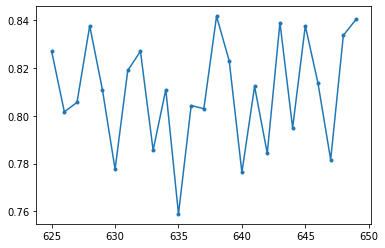

In [119]:
#Graph results
plt.plot(range(625,650,1), final_accuracy_node_list, label = "Predicted Accuracies", marker = ".")

In [120]:
#Best value is 638. Re run model with this value
build_model_output = build_model(638,.5, .001)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 5.2413 - accuracy: 0.53 - ETA: 0s - loss: 2.8412 - accuracy: 0.59 - 0s 1ms/step - loss: 2.5705 - accuracy: 0.6070
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.4661 - accuracy: 0.59 - ETA: 0s - loss: 1.7855 - accuracy: 0.64 - 0s 1ms/step - loss: 1.6449 - accuracy: 0.6607
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.4600 - accuracy: 0.56 - ETA: 0s - loss: 1.3177 - accuracy: 0.69 - 0s 1ms/step - loss: 1.2607 - accuracy: 0.7114
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.0025 - accuracy: 0.65 - ETA: 0s - loss: 1.0616 - accuracy: 0.71 - 0s 1ms/step - loss: 1.0060 - accuracy: 0.7260
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.84 - ETA: 0s - loss: 0.8293 - accuracy: 0.75 - 0s 1ms/step - loss: 0.8475 - accuracy: 0.7469
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6

Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.78 - ETA: 0s - loss: 0.3579 - accuracy: 0.82 - 0s 985us/step - loss: 0.3479 - accuracy: 0.8295
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.75 - ETA: 0s - loss: 0.3299 - accuracy: 0.85 - 0s 978us/step - loss: 0.3305 - accuracy: 0.8486
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.78 - ETA: 0s - loss: 0.3256 - accuracy: 0.85 - 0s 974us/step - loss: 0.3291 - accuracy: 0.8468
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.87 - ETA: 0s - loss: 0.3272 - accuracy: 0.84 - 0s 1ms/step - loss: 0.3222 - accuracy: 0.8504
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.90 - 0s 765us/step - loss: 0.3520 - accuracy: 0.8522
0.8521970510482788


In [124]:
#Optimize dropout rate
#Loop through nodes
dropout_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
final_accuracy_dropout_list = []

for i in dropout_list:
    build_model_output = build_model(638, i, .001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_dropout_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 1.7269 - accuracy: 0.56 - ETA: 0s - loss: 1.1454 - accuracy: 0.61 - 0s 1ms/step - loss: 1.0712 - accuracy: 0.6394
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.71 - ETA: 0s - loss: 0.8379 - accuracy: 0.73 - 0s 1ms/step - loss: 0.8703 - accuracy: 0.7207
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.71 - ETA: 0s - loss: 0.7791 - accuracy: 0.72 - 0s 1ms/step - loss: 0.7409 - accuracy: 0.7367
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.84 - ETA: 0s - loss: 0.7562 - accuracy: 0.75 - 0s 1ms/step - loss: 0.7435 - accuracy: 0.7602
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.93 - 0s 814us/step - loss: 0.3531 - accuracy: 0.8522
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.65 - ETA: 0s - loss: 1.3785 - accuracy: 0.63 - 

24/24 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.87 - 0s 803us/step - loss: 0.4358 - accuracy: 0.7923
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 9.0394 - accuracy: 0.53 - ETA: 0s - loss: 7.2944 - accuracy: 0.56 - 0s 1ms/step - loss: 6.9991 - accuracy: 0.5684
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 7.2107 - accuracy: 0.59 - ETA: 0s - loss: 4.7238 - accuracy: 0.59 - 0s 1ms/step - loss: 4.5538 - accuracy: 0.5986
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 3.0438 - accuracy: 0.68 - ETA: 0s - loss: 3.0751 - accuracy: 0.63 - 0s 983us/step - loss: 3.0515 - accuracy: 0.6323
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 3.0926 - accuracy: 0.62 - ETA: 0s - loss: 2.4010 - accuracy: 0.64 - 0s 977us/step - loss: 2.2389 - accuracy: 0.6421
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.78 - 0s 835us/step - loss: 0.6584 - accuracy: 0.7257


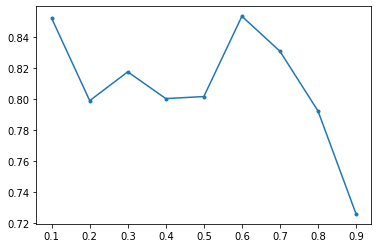

In [125]:
#Graph results
plt.plot(dropout_list, final_accuracy_dropout_list, label = "Predicted Accuracies", marker = ".")

In [132]:
build_model_output = build_model(480, .6, .001)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
final_accuracy_dropout_list.append(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 14.2575 - accuracy: 0.218 - ETA: 0s - loss: 4.3825 - accuracy: 0.564 - 0s 1ms/step - loss: 3.9948 - accuracy: 0.5746
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.6154 - accuracy: 0.43 - ETA: 0s - loss: 2.4711 - accuracy: 0.63 - 0s 1ms/step - loss: 2.3011 - accuracy: 0.6306
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 2.5064 - accuracy: 0.62 - ETA: 0s - loss: 1.8156 - accuracy: 0.65 - 0s 943us/step - loss: 1.7558 - accuracy: 0.6581
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.6302 - accuracy: 0.75 - ETA: 0s - loss: 1.2814 - accuracy: 0.69 - 0s 1ms/step - loss: 1.2041 - accuracy: 0.6998
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 1.1723 - accuracy: 0.62 - ETA: 0s - loss: 0.9583 - accuracy: 0.70 - 0s 973us/step - loss: 0.9208 - accuracy: 0.7136
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.8594 - accura

71/71 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.84 - ETA: 0s - loss: 0.3343 - accuracy: 0.84 - 0s 999us/step - loss: 0.3391 - accuracy: 0.8446
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.90 - ETA: 0s - loss: 0.3438 - accuracy: 0.83 - 0s 985us/step - loss: 0.3383 - accuracy: 0.8424
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.93 - ETA: 0s - loss: 0.3427 - accuracy: 0.85 - 0s 1ms/step - loss: 0.3430 - accuracy: 0.8495
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.81 - ETA: 0s - loss: 0.3415 - accuracy: 0.83 - 0s 927us/step - loss: 0.3351 - accuracy: 0.8455
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.87 - ETA: 0s - loss: 0.3396 - accuracy: 0.84 - 0s 925us/step - loss: 0.3390 - accuracy: 0.8472
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0

In [133]:
#Optimize learning rate
#Loop through nodes
learning_rate_list = [.000001, .00001, .0001, .001, .01, .1]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(480, .6, i)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_learning_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 8.0754 - accuracy: 0.37 - ETA: 0s - loss: 6.5511 - accuracy: 0.43 - 0s 1ms/step - loss: 6.3602 - accuracy: 0.4512
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 2.1936 - accuracy: 0.68 - ETA: 0s - loss: 6.5446 - accuracy: 0.44 - 0s 983us/step - loss: 6.3712 - accuracy: 0.4529
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 5.2497 - accuracy: 0.46 - ETA: 0s - loss: 6.1520 - accuracy: 0.47 - 0s 1ms/step - loss: 6.1644 - accuracy: 0.4640
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 4.7126 - accuracy: 0.53 - ETA: 0s - loss: 5.8150 - accuracy: 0.43 - 0s 1ms/step - loss: 5.8884 - accuracy: 0.4418
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 4.8044 - accuracy: 0.34 - 0s 713us/step - loss: 4.0416 - accuracy: 0.4075
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 5.7953 - accuracy: 0.40 - ETA: 0s - loss: 5.5357 - accuracy: 0.48 

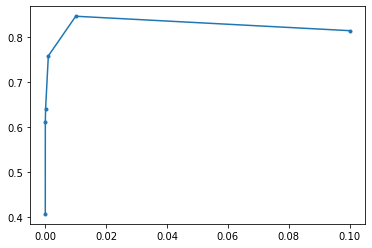

In [134]:
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")

In [135]:
#Optimize learning rate
#Loop through nodes
learning_rate_list = [.000001, .00001, .0001, .001, .01]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(480, .6, i)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_learning_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 4.0346 - accuracy: 0.50 - ETA: 0s - loss: 7.5098 - accuracy: 0.44 - 0s 1ms/step - loss: 7.3197 - accuracy: 0.4520
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 6.2149 - accuracy: 0.46 - ETA: 0s - loss: 7.5087 - accuracy: 0.44 - 0s 975us/step - loss: 7.7089 - accuracy: 0.4356
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 4.0344 - accuracy: 0.50 - ETA: 0s - loss: 7.8416 - accuracy: 0.43 - 0s 987us/step - loss: 7.5143 - accuracy: 0.4369
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 6.1917 - accuracy: 0.46 - ETA: 0s - loss: 7.2256 - accuracy: 0.44 - 0s 956us/step - loss: 7.2518 - accuracy: 0.4458
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 5.2404 - accuracy: 0.40 - 0s 718us/step - loss: 4.9098 - accuracy: 0.3822
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 8.2052 - accuracy: 0.43 - ETA: 0s - loss: 7.8419 - accuracy: 0

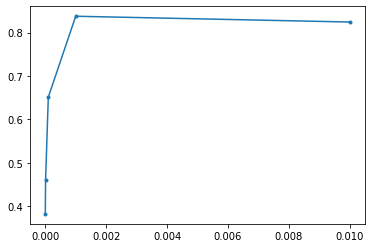

In [136]:
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")

In [143]:
build_model_output = build_model(128, .6, .001)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
final_accuracy_dropout_list.append(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 4.9796 - accuracy: 0.59 - ETA: 0s - loss: 7.3335 - accuracy: 0.55 - 0s 969us/step - loss: 7.0161 - accuracy: 0.5551
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.8455 - accuracy: 0.65 - ETA: 0s - loss: 4.9264 - accuracy: 0.58 - 0s 832us/step - loss: 4.8363 - accuracy: 0.5866
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 6.1294 - accuracy: 0.59 - ETA: 0s - loss: 3.6536 - accuracy: 0.60 - 0s 839us/step - loss: 3.6253 - accuracy: 0.6048
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 5.2958 - accuracy: 0.50 - ETA: 0s - loss: 2.5914 - accuracy: 0.62 - 0s 892us/step - loss: 2.5363 - accuracy: 0.6239
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 2.1995 - accuracy: 0.62 - ETA: 0s - loss: 1.8424 - accuracy: 0.63 - 0s 822us/step - loss: 1.8162 - accuracy: 0.6332
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 2.0676 - acc

71/71 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.90 - ETA: 0s - loss: 0.3582 - accuracy: 0.83 - 0s 843us/step - loss: 0.3550 - accuracy: 0.8370
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.78 - ETA: 0s - loss: 0.3480 - accuracy: 0.83 - 0s 835us/step - loss: 0.3519 - accuracy: 0.8366
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.93 - ETA: 0s - loss: 0.3433 - accuracy: 0.84 - 0s 833us/step - loss: 0.3450 - accuracy: 0.8419
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.90 - ETA: 0s - loss: 0.3404 - accuracy: 0.84 - 0s 802us/step - loss: 0.3392 - accuracy: 0.8504
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.84 - ETA: 0s - loss: 0.3473 - accuracy: 0.84 - 0s 784us/step - loss: 0.3479 - accuracy: 0.8468
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2812 - accuracy:

In [153]:
#Loop through nodes
final_accuracy_node_list = []

for i in range(110,130, 1):
    build_model_output = build_model(i, .6, .001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 9.5768 - accuracy: 0.50 - ETA: 0s - loss: 7.4653 - accuracy: 0.56 - 0s 925us/step - loss: 7.0724 - accuracy: 0.5644
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 4.5603 - accuracy: 0.62 - ETA: 0s - loss: 4.8731 - accuracy: 0.61 - 0s 874us/step - loss: 4.8146 - accuracy: 0.6141
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 4.7789 - accuracy: 0.50 - ETA: 0s - loss: 3.7280 - accuracy: 0.59 - 0s 833us/step - loss: 3.6325 - accuracy: 0.5986
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 4.4090 - accuracy: 0.40 - ETA: 0s - loss: 2.7647 - accuracy: 0.60 - 0s 814us/step - loss: 2.7115 - accuracy: 0.6075
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.59 - ETA: 0s - loss: 1.9726 - accuracy: 0.62 - 0s 967us/step - loss: 1.7936 - accuracy: 0.6403
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 1.3766 - acc

71/71 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.78 - ETA: 0s - loss: 0.3410 - accuracy: 0.84 - 0s 889us/step - loss: 0.3426 - accuracy: 0.8459
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.78 - ETA: 0s - loss: 0.3495 - accuracy: 0.83 - 0s 813us/step - loss: 0.3501 - accuracy: 0.8370
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.78 - ETA: 0s - loss: 0.3490 - accuracy: 0.84 - 0s 828us/step - loss: 0.3490 - accuracy: 0.8415
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.84 - ETA: 0s - loss: 0.3500 - accuracy: 0.84 - 0s 808us/step - loss: 0.3508 - accuracy: 0.8455
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.78 - ETA: 0s - loss: 0.3518 - accuracy: 0.84 - 0s 809us/step - loss: 0.3529 - accuracy: 0.8419
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2626 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.75 - ETA: 0s - loss: 0.3662 - accuracy: 0.83 - 0s 814us/step - loss: 0.3619 - accuracy: 0.8335
Epoch 39/50
71/71 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.84 - ETA: 0s - loss: 0.3583 - accuracy: 0.83 - 0s 790us/step - loss: 0.3563 - accuracy: 0.8353
Epoch 40/50
71/71 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.87 - ETA: 0s - loss: 0.3558 - accuracy: 0.83 - 0s 782us/step - loss: 0.3556 - accuracy: 0.8366
Epoch 41/50
71/71 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.81 - ETA: 0s - loss: 0.3608 - accuracy: 0.83 - 0s 800us/step - loss: 0.3644 - accuracy: 0.8313
Epoch 42/50
71/71 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.84 - ETA: 0s - loss: 0.3478 - accuracy: 0.84 - 0s 806us/step - loss: 0.3492 - accuracy: 0.8388
Epoch 43/50
71/71 [==============================] - ETA: 0s - loss: 0.3411 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.65 - ETA: 0s - loss: 0.3793 - accuracy: 0.82 - 0s 816us/step - loss: 0.3828 - accuracy: 0.8233
Epoch 32/50
71/71 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.71 - ETA: 0s - loss: 0.3617 - accuracy: 0.83 - 0s 792us/step - loss: 0.3624 - accuracy: 0.8330
Epoch 33/50
71/71 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.87 - ETA: 0s - loss: 0.3647 - accuracy: 0.83 - 0s 779us/step - loss: 0.3648 - accuracy: 0.8304
Epoch 34/50
71/71 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.87 - ETA: 0s - loss: 0.3641 - accuracy: 0.83 - 0s 757us/step - loss: 0.3647 - accuracy: 0.8335
Epoch 35/50
71/71 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.84 - ETA: 0s - loss: 0.3526 - accuracy: 0.83 - 0s 802us/step - loss: 0.3508 - accuracy: 0.8375
Epoch 36/50
71/71 [==============================] - ETA: 0s - loss: 0.3203 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.90 - ETA: 0s - loss: 0.3784 - accuracy: 0.82 - 0s 814us/step - loss: 0.3790 - accuracy: 0.8228
Epoch 25/50
71/71 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.87 - ETA: 0s - loss: 0.3739 - accuracy: 0.82 - 0s 788us/step - loss: 0.3736 - accuracy: 0.8286
Epoch 26/50
71/71 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.87 - ETA: 0s - loss: 0.3776 - accuracy: 0.83 - 0s 780us/step - loss: 0.3775 - accuracy: 0.8339
Epoch 27/50
71/71 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.90 - ETA: 0s - loss: 0.3768 - accuracy: 0.81 - 0s 790us/step - loss: 0.3766 - accuracy: 0.8210
Epoch 28/50
71/71 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.84 - ETA: 0s - loss: 0.3732 - accuracy: 0.82 - 0s 743us/step - loss: 0.3732 - accuracy: 0.8237
Epoch 29/50
71/71 [==============================] - ETA: 0s - loss: 0.2767 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.71 - ETA: 0s - loss: 0.4034 - accuracy: 0.80 - 0s 838us/step - loss: 0.3999 - accuracy: 0.8113
Epoch 18/50
71/71 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.78 - ETA: 0s - loss: 0.3959 - accuracy: 0.81 - 0s 837us/step - loss: 0.3930 - accuracy: 0.8193
Epoch 19/50
71/71 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.75 - ETA: 0s - loss: 0.3953 - accuracy: 0.81 - 0s 862us/step - loss: 0.3921 - accuracy: 0.8188
Epoch 20/50
71/71 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.84 - ETA: 0s - loss: 0.3822 - accuracy: 0.82 - 0s 910us/step - loss: 0.3867 - accuracy: 0.8255
Epoch 21/50
71/71 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.87 - ETA: 0s - loss: 0.3768 - accuracy: 0.82 - 0s 787us/step - loss: 0.3743 - accuracy: 0.8268
Epoch 22/50
71/71 [==============================] - ETA: 0s - loss: 0.3956 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.78 - ETA: 0s - loss: 0.5264 - accuracy: 0.74 - 0s 797us/step - loss: 0.5244 - accuracy: 0.7487
Epoch 11/50
71/71 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.84 - ETA: 0s - loss: 0.4805 - accuracy: 0.77 - 0s 767us/step - loss: 0.4795 - accuracy: 0.7718
Epoch 12/50
71/71 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.78 - ETA: 0s - loss: 0.4850 - accuracy: 0.76 - 0s 794us/step - loss: 0.4797 - accuracy: 0.7731
Epoch 13/50
71/71 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.78 - ETA: 0s - loss: 0.4485 - accuracy: 0.78 - 0s 941us/step - loss: 0.4446 - accuracy: 0.7917
Epoch 14/50
71/71 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.59 - ETA: 0s - loss: 0.4549 - accuracy: 0.78 - 0s 847us/step - loss: 0.4539 - accuracy: 0.7877
Epoch 15/50
71/71 [==============================] - ETA: 0s - loss: 0.5846 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 5.8870 - accuracy: 0.59 - ETA: 0s - loss: 4.3108 - accuracy: 0.59 - 0s 789us/step - loss: 4.2397 - accuracy: 0.5977
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 4.3109 - accuracy: 0.65 - ETA: 0s - loss: 3.1194 - accuracy: 0.61 - 0s 790us/step - loss: 3.1142 - accuracy: 0.6199
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 2.7567 - accuracy: 0.53 - ETA: 0s - loss: 2.2989 - accuracy: 0.62 - 0s 753us/step - loss: 2.2990 - accuracy: 0.6257
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 3.0110 - accuracy: 0.56 - ETA: 0s - loss: 1.6942 - accuracy: 0.65 - 0s 871us/step - loss: 1.6203 - accuracy: 0.6559
Epoch 7/50
71/71 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.53 - ETA: 0s - loss: 1.1635 - accuracy: 0.65 - 0s 823us/step - loss: 1.1635 - accuracy: 0.6581
Epoch 8/50
71/71 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.71

71/71 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.93 - ETA: 0s - loss: 0.3573 - accuracy: 0.84 - 0s 745us/step - loss: 0.3573 - accuracy: 0.8401
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.81 - ETA: 0s - loss: 0.3523 - accuracy: 0.83 - 0s 793us/step - loss: 0.3529 - accuracy: 0.8361
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.65 - ETA: 0s - loss: 0.3552 - accuracy: 0.82 - 0s 830us/step - loss: 0.3552 - accuracy: 0.8295
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.87 - 0s 762us/step - loss: 0.3364 - accuracy: 0.8589
Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 16.3866 - accuracy: 0.281 - ETA: 0s - loss: 6.9367 - accuracy: 0.528 - 0s 828us/step - loss: 6.6944 - accuracy: 0.5342
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 7.0826 - accuracy: 0.46 - ETA: 0s - loss: 4.4223 - accuracy

71/71 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3684 - accuracy: 0.83 - 0s 761us/step - loss: 0.3685 - accuracy: 0.8366
Epoch 41/50
71/71 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.81 - ETA: 0s - loss: 0.3609 - accuracy: 0.83 - 0s 794us/step - loss: 0.3609 - accuracy: 0.8366
Epoch 42/50
71/71 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.87 - ETA: 0s - loss: 0.3548 - accuracy: 0.83 - 0s 747us/step - loss: 0.3548 - accuracy: 0.8397
Epoch 43/50
71/71 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.87 - ETA: 0s - loss: 0.3559 - accuracy: 0.83 - 0s 785us/step - loss: 0.3572 - accuracy: 0.8366
Epoch 44/50
71/71 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.84 - ETA: 0s - loss: 0.3526 - accuracy: 0.83 - 0s 767us/step - loss: 0.3541 - accuracy: 0.8379
Epoch 45/50
71/71 [==============================] - ETA: 0s - loss: 0.3681 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.81 - ETA: 0s - loss: 0.3720 - accuracy: 0.83 - 0s 797us/step - loss: 0.3699 - accuracy: 0.8321
Epoch 34/50
71/71 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.84 - ETA: 0s - loss: 0.3506 - accuracy: 0.83 - 0s 795us/step - loss: 0.3519 - accuracy: 0.8361
Epoch 35/50
71/71 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.84 - ETA: 0s - loss: 0.3550 - accuracy: 0.83 - 0s 804us/step - loss: 0.3579 - accuracy: 0.8339
Epoch 36/50
71/71 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.84 - ETA: 0s - loss: 0.3644 - accuracy: 0.83 - 0s 769us/step - loss: 0.3624 - accuracy: 0.8326
Epoch 37/50
71/71 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.81 - ETA: 0s - loss: 0.3585 - accuracy: 0.84 - 0s 782us/step - loss: 0.3560 - accuracy: 0.8415
Epoch 38/50
71/71 [==============================] - ETA: 0s - loss: 0.2932 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.81 - ETA: 0s - loss: 0.3887 - accuracy: 0.81 - 0s 753us/step - loss: 0.3889 - accuracy: 0.8144
Epoch 27/50
71/71 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.84 - ETA: 0s - loss: 0.3787 - accuracy: 0.82 - 0s 801us/step - loss: 0.3808 - accuracy: 0.8197
Epoch 28/50
71/71 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.75 - ETA: 0s - loss: 0.3769 - accuracy: 0.82 - 0s 798us/step - loss: 0.3781 - accuracy: 0.8233
Epoch 29/50
71/71 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.78 - ETA: 0s - loss: 0.3826 - accuracy: 0.82 - 0s 765us/step - loss: 0.3817 - accuracy: 0.8264
Epoch 30/50
71/71 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.78 - ETA: 0s - loss: 0.3674 - accuracy: 0.82 - 0s 801us/step - loss: 0.3677 - accuracy: 0.8286
Epoch 31/50
71/71 [==============================] - ETA: 0s - loss: 0.3465 - accuracy:

Epoch 20/50
71/71 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.68 - ETA: 0s - loss: 0.3972 - accuracy: 0.81 - 0s 782us/step - loss: 0.3980 - accuracy: 0.8139
Epoch 21/50
71/71 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.65 - ETA: 0s - loss: 0.3940 - accuracy: 0.81 - 0s 739us/step - loss: 0.3940 - accuracy: 0.8144
Epoch 22/50
71/71 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.84 - ETA: 0s - loss: 0.3837 - accuracy: 0.82 - 0s 789us/step - loss: 0.3836 - accuracy: 0.8250
Epoch 23/50
71/71 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.75 - ETA: 0s - loss: 0.3844 - accuracy: 0.82 - 0s 834us/step - loss: 0.3831 - accuracy: 0.8219
Epoch 24/50
71/71 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.81 - ETA: 0s - loss: 0.3922 - accuracy: 0.81 - 0s 754us/step - loss: 0.3920 - accuracy: 0.8184
Epoch 25/50
71/71 [==============================] - ETA: 0s - loss: 0.5028

71/71 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.84 - ETA: 0s - loss: 0.4306 - accuracy: 0.80 - 0s 802us/step - loss: 0.4265 - accuracy: 0.8051
Epoch 15/50
71/71 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.87 - ETA: 0s - loss: 0.4062 - accuracy: 0.81 - 0s 792us/step - loss: 0.4121 - accuracy: 0.8162
Epoch 16/50
71/71 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.81 - ETA: 0s - loss: 0.4117 - accuracy: 0.80 - 0s 852us/step - loss: 0.4131 - accuracy: 0.8037
Epoch 17/50
71/71 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.84 - ETA: 0s - loss: 0.4126 - accuracy: 0.81 - 0s 808us/step - loss: 0.4066 - accuracy: 0.8162
Epoch 18/50
71/71 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - ETA: 0s - loss: 0.4027 - accuracy: 0.81 - 0s 769us/step - loss: 0.4012 - accuracy: 0.8122
Epoch 19/50
71/71 [==============================] - ETA: 0s - loss: 0.2780 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.71 - ETA: 0s - loss: 0.9212 - accuracy: 0.68 - 0s 771us/step - loss: 0.9158 - accuracy: 0.6856
Epoch 8/50
71/71 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.75 - ETA: 0s - loss: 0.7424 - accuracy: 0.70 - 0s 816us/step - loss: 0.7408 - accuracy: 0.6972
Epoch 9/50
71/71 [==============================] - ETA: 0s - loss: 1.0419 - accuracy: 0.78 - ETA: 0s - loss: 0.6040 - accuracy: 0.73 - 0s 865us/step - loss: 0.5893 - accuracy: 0.7393
Epoch 10/50
71/71 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.78 - ETA: 0s - loss: 0.5093 - accuracy: 0.75 - 0s 814us/step - loss: 0.5063 - accuracy: 0.7611
Epoch 11/50
71/71 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.71 - ETA: 0s - loss: 0.4617 - accuracy: 0.77 - 0s 814us/step - loss: 0.4626 - accuracy: 0.7798
Epoch 12/50
71/71 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0

24/24 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.90 - 0s 772us/step - loss: 0.3319 - accuracy: 0.8589
Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 10.4936 - accuracy: 0.531 - ETA: 0s - loss: 6.7331 - accuracy: 0.565 - 0s 951us/step - loss: 6.3509 - accuracy: 0.5768
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 8.3201 - accuracy: 0.53 - ETA: 0s - loss: 4.5745 - accuracy: 0.60 - 0s 878us/step - loss: 4.4708 - accuracy: 0.6044
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.5491 - accuracy: 0.62 - ETA: 0s - loss: 3.3518 - accuracy: 0.60 - 0s 808us/step - loss: 3.2812 - accuracy: 0.6097
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 2.4228 - accuracy: 0.65 - ETA: 0s - loss: 2.1828 - accuracy: 0.63 - 0s 819us/step - loss: 2.1552 - accuracy: 0.6363
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 3.5504 - accuracy: 0.43 - ETA: 0s - loss: 1.5594 - accuracy: 0

71/71 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.84 - ETA: 0s - loss: 0.3573 - accuracy: 0.83 - 0s 796us/step - loss: 0.3569 - accuracy: 0.8375
Epoch 45/50
71/71 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.84 - ETA: 0s - loss: 0.3468 - accuracy: 0.84 - 0s 772us/step - loss: 0.3495 - accuracy: 0.8468
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.81 - ETA: 0s - loss: 0.3422 - accuracy: 0.84 - 0s 799us/step - loss: 0.3426 - accuracy: 0.8450
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.84 - ETA: 0s - loss: 0.3463 - accuracy: 0.83 - 0s 796us/step - loss: 0.3464 - accuracy: 0.8379
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.78 - ETA: 0s - loss: 0.3505 - accuracy: 0.84 - 0s 904us/step - loss: 0.3505 - accuracy: 0.8410
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.2444 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.68 - ETA: 0s - loss: 0.3650 - accuracy: 0.83 - 0s 785us/step - loss: 0.3633 - accuracy: 0.8384
Epoch 38/50
71/71 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.90 - ETA: 0s - loss: 0.3569 - accuracy: 0.83 - 0s 806us/step - loss: 0.3587 - accuracy: 0.8361
Epoch 39/50
71/71 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.84 - ETA: 0s - loss: 0.3574 - accuracy: 0.83 - 0s 800us/step - loss: 0.3542 - accuracy: 0.8415
Epoch 40/50
71/71 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.84 - ETA: 0s - loss: 0.3700 - accuracy: 0.82 - 0s 796us/step - loss: 0.3706 - accuracy: 0.8282
Epoch 41/50
71/71 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.84 - ETA: 0s - loss: 0.3597 - accuracy: 0.83 - 0s 836us/step - loss: 0.3582 - accuracy: 0.8326
Epoch 42/50
71/71 [==============================] - ETA: 0s - loss: 0.2282 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.81 - ETA: 0s - loss: 0.3644 - accuracy: 0.83 - 0s 789us/step - loss: 0.3657 - accuracy: 0.8308
Epoch 31/50
71/71 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.81 - ETA: 0s - loss: 0.3702 - accuracy: 0.83 - 0s 803us/step - loss: 0.3702 - accuracy: 0.8357
Epoch 32/50
71/71 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.78 - ETA: 0s - loss: 0.3715 - accuracy: 0.82 - 0s 855us/step - loss: 0.3700 - accuracy: 0.8282
Epoch 33/50
71/71 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.87 - ETA: 0s - loss: 0.3688 - accuracy: 0.82 - 0s 882us/step - loss: 0.3649 - accuracy: 0.8295
Epoch 34/50
71/71 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.87 - ETA: 0s - loss: 0.3523 - accuracy: 0.84 - 0s 808us/step - loss: 0.3517 - accuracy: 0.8424
Epoch 35/50
71/71 [==============================] - ETA: 0s - loss: 0.2829 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.84 - ETA: 0s - loss: 0.3852 - accuracy: 0.82 - 0s 756us/step - loss: 0.3849 - accuracy: 0.8282
Epoch 24/50
71/71 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.78 - ETA: 0s - loss: 0.3832 - accuracy: 0.82 - 0s 784us/step - loss: 0.3831 - accuracy: 0.8233
Epoch 25/50
71/71 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.75 - ETA: 0s - loss: 0.3949 - accuracy: 0.82 - 0s 758us/step - loss: 0.3946 - accuracy: 0.8202
Epoch 26/50
71/71 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.81 - ETA: 0s - loss: 0.3718 - accuracy: 0.83 - 0s 866us/step - loss: 0.3759 - accuracy: 0.8313
Epoch 27/50
71/71 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.78 - ETA: 0s - loss: 0.3784 - accuracy: 0.82 - 0s 792us/step - loss: 0.3780 - accuracy: 0.8282
Epoch 28/50
71/71 [==============================] - ETA: 0s - loss: 0.4103 - accuracy:

71/71 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.90 - ETA: 0s - loss: 0.4395 - accuracy: 0.80 - 0s 796us/step - loss: 0.4399 - accuracy: 0.8020
Epoch 17/50
71/71 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.78 - ETA: 0s - loss: 0.4397 - accuracy: 0.79 - 0s 767us/step - loss: 0.4422 - accuracy: 0.7971
Epoch 18/50
71/71 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.78 - ETA: 0s - loss: 0.4584 - accuracy: 0.78 - 0s 851us/step - loss: 0.4506 - accuracy: 0.7842
Epoch 19/50
71/71 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.87 - ETA: 0s - loss: 0.4347 - accuracy: 0.80 - 0s 801us/step - loss: 0.4340 - accuracy: 0.8068
Epoch 20/50
71/71 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.68 - ETA: 0s - loss: 0.4303 - accuracy: 0.80 - 0s 799us/step - loss: 0.4291 - accuracy: 0.8055
Epoch 21/50
71/71 [==============================] - ETA: 0s - loss: 0.3920 - accuracy:

Epoch 10/50
71/71 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.71 - ETA: 0s - loss: 0.4506 - accuracy: 0.79 - 0s 784us/step - loss: 0.4521 - accuracy: 0.7931
Epoch 11/50
71/71 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.81 - ETA: 0s - loss: 0.4405 - accuracy: 0.79 - 0s 824us/step - loss: 0.4375 - accuracy: 0.7931
Epoch 12/50
71/71 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.65 - ETA: 0s - loss: 0.4333 - accuracy: 0.79 - 0s 754us/step - loss: 0.4321 - accuracy: 0.7984
Epoch 13/50
71/71 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.78 - ETA: 0s - loss: 0.4239 - accuracy: 0.80 - 0s 775us/step - loss: 0.4226 - accuracy: 0.8037
Epoch 14/50
71/71 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.87 - ETA: 0s - loss: 0.4125 - accuracy: 0.80 - 0s 741us/step - loss: 0.4125 - accuracy: 0.8095
Epoch 15/50
71/71 [==============================] - ETA: 0s - loss: 0.3072

71/71 [==============================] - ETA: 0s - loss: 3.6277 - accuracy: 0.46 - ETA: 0s - loss: 2.9738 - accuracy: 0.63 - 0s 781us/step - loss: 2.9562 - accuracy: 0.6288
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 1.3434 - accuracy: 0.71 - ETA: 0s - loss: 2.1609 - accuracy: 0.64 - 0s 788us/step - loss: 2.1754 - accuracy: 0.6385
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 1.7577 - accuracy: 0.78 - ETA: 0s - loss: 1.5170 - accuracy: 0.66 - 0s 853us/step - loss: 1.4787 - accuracy: 0.6710
Epoch 7/50
71/71 [==============================] - ETA: 0s - loss: 0.9058 - accuracy: 0.68 - ETA: 0s - loss: 1.0922 - accuracy: 0.67 - 0s 1ms/step - loss: 1.0205 - accuracy: 0.6812
Epoch 8/50
71/71 [==============================] - ETA: 0s - loss: 0.9474 - accuracy: 0.65 - ETA: 0s - loss: 0.8369 - accuracy: 0.70 - 0s 796us/step - loss: 0.8116 - accuracy: 0.7123
Epoch 9/50
71/71 [==============================] - ETA: 0s - loss: 1.0142 - accuracy: 0.65 -

71/71 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.87 - ETA: 0s - loss: 0.3469 - accuracy: 0.84 - 0s 795us/step - loss: 0.3471 - accuracy: 0.8419
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.81 - ETA: 0s - loss: 0.3520 - accuracy: 0.83 - 0s 782us/step - loss: 0.3491 - accuracy: 0.8384
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.90 - 0s 760us/step - loss: 0.3243 - accuracy: 0.8682


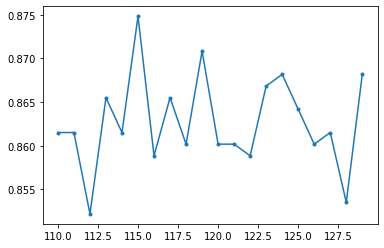

In [154]:
plt.plot(range(110,130,1), final_accuracy_node_list, label = "Predicted Accuracies", marker = ".")

In [183]:
build_model_output = build_model(128, .6, .001)
fit_model_output = fit_model(build_model_output, train_data2, train_labels2, 50)
final_accuracy = evaluate_model(build_model_output, dev_data2, dev_labels2)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 22.4971 - accuracy: 0.343 - ETA: 0s - loss: 7.2939 - accuracy: 0.539 - 0s 919us/step - loss: 6.9438 - accuracy: 0.5457
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 5.7411 - accuracy: 0.68 - ETA: 0s - loss: 4.1384 - accuracy: 0.60 - 0s 841us/step - loss: 4.0291 - accuracy: 0.6052
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 2.0414 - accuracy: 0.71 - ETA: 0s - loss: 3.0393 - accuracy: 0.61 - 0s 826us/step - loss: 2.9784 - accuracy: 0.6172
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.9879 - accuracy: 0.65 - ETA: 0s - loss: 2.1754 - accuracy: 0.63 - 0s 921us/step - loss: 2.1188 - accuracy: 0.6297
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 2.0251 - accuracy: 0.53 - ETA: 0s - loss: 1.4652 - accuracy: 0.68 - 0s 836us/step - loss: 1.4632 - accuracy: 0.6803
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 1.0500 - 

71/71 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.81 - ETA: 0s - loss: 0.3348 - accuracy: 0.85 - 0s 854us/step - loss: 0.3356 - accuracy: 0.8521
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.87 - ETA: 0s - loss: 0.3356 - accuracy: 0.84 - 0s 847us/step - loss: 0.3342 - accuracy: 0.8486
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.81 - ETA: 0s - loss: 0.3456 - accuracy: 0.83 - 0s 801us/step - loss: 0.3452 - accuracy: 0.8388
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.84 - ETA: 0s - loss: 0.3335 - accuracy: 0.84 - 0s 815us/step - loss: 0.3306 - accuracy: 0.8490
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.90 - ETA: 0s - loss: 0.3355 - accuracy: 0.85 - 0s 757us/step - loss: 0.3359 - accuracy: 0.8499
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.2958 - accuracy:

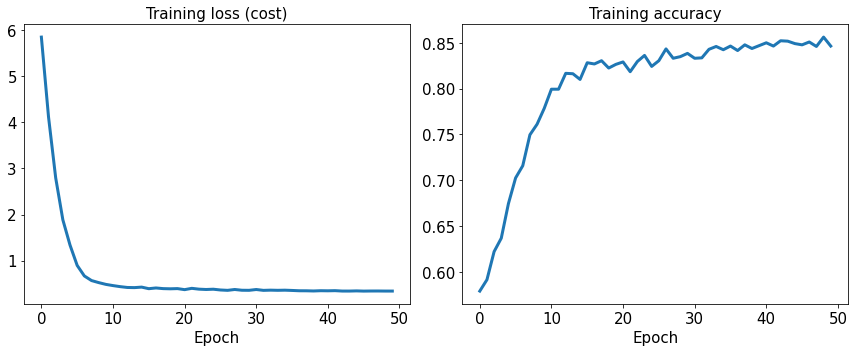

In [177]:
# plot training cost and accuracy
hist = fit_model_output.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


### Try with Keras Tuners

In [83]:
class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = keras.Sequential()

        # Range of models to build
        for i in range(hp.Int('num_layers', 2, 20)):

            model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=32,
                                                max_value=512, 
                                                step=32),
                                   activation='relu'))
        
        # Output layer
        model.add(keras.layers.Dense(self.num_classes, activation='relu'))
        
        # Compile the constructed model and return it
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model
    


hypermodel = MyHyperModel(num_classes=1)    

INFO:tensorflow:Reloading Oracle from existing project ./divorce_test3/oracle.json
INFO:tensorflow:Reloading Tuner from ./divorce_test3/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 8.2468 - accuracy: 0.40 - ETA: 0s - loss: 5.5983 - accuracy: 0.55 - ETA: 0s - loss: 6.3251 - accuracy: 0.51 - 0s 2ms/step - loss: 6.6601 - accuracy: 0.5009
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 6.8038 - accuracy: 0.53 - ETA: 0s - loss: 8.0927 - accuracy: 0.42 - ETA: 0s - loss: 7.2093 - accuracy: 0.47 - 0s 2ms/step - loss: 6.9479 - accuracy: 0.4893
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 5.8618 - accuracy: 0.59 - ETA: 0s - loss: 7.1651 - accuracy: 0.47 - ETA: 0s - loss: 7.6122 - accuracy: 0.45 - 0s 2ms/step - loss: 7.6595 - accuracy: 0.4520
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 7.7174 - accuracy: 0.50 - ETA: 0s - loss: 8.3128 - accuracy: 0.43 - ETA: 0

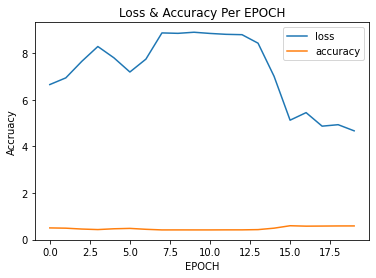

In [84]:

# Construct the Hyperband tuner using the hypermodel class created
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    seed=10,
    project_name='keras_results')


# Search for the best parameters of the neural network using the contructed Hypberband tuner
tuner.search(train_data, train_labels,
             epochs=10,
             validation_data=(train_data, train_labels))

# Get the best hyperparameters from the search
params = tuner.get_best_hyperparameters()[0]

# Build the model using the best hyperparameters
model = tuner.hypermodel.build(params)

# Train the best fitting model
model.fit(train_data, train_labels, epochs=20)

# Check the accuracy plots
hyperband_accuracy_df = pd.DataFrame(model.history.history)

hyperband_accuracy_df[['loss', 'accuracy']].plot()
plt.title('Loss & Accuracy Per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Accruacy')
plt.show()

INFO:tensorflow:Reloading Oracle from existing project ./divorce test/oracle.json
INFO:tensorflow:Reloading Tuner from ./divorce test/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 6.9437 - accuracy: 0.46 - ETA: 0s - loss: 6.9746 - accuracy: 0.47 - ETA: 0s - loss: 5.4618 - accuracy: 0.52 - ETA: 0s - loss: 4.8778 - accuracy: 0.55 - 0s 3ms/step - loss: 4.7022 - accuracy: 0.5537
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 1.1366 - accuracy: 0.56 - ETA: 0s - loss: 1.1414 - accuracy: 0.66 - ETA: 0s - loss: 2.1812 - accuracy: 0.64 - 0s 2ms/step - loss: 2.8266 - accuracy: 0.6323
Epoch 3/15
71/71 [==============================] - ETA: 0s - loss: 5.7723 - accuracy: 0.62 - ETA: 0s - loss: 4.5647 - accuracy: 0.58 - ETA: 0s - loss: 4.1036 - accuracy: 0.61 - ETA: 0s - loss: 4.1809 - accuracy: 0.60 - 0s 2ms/step - loss: 4.1669 - accuracy: 0.6044
Epoch 4/15
71/71 [==============================] - ETA: 0s 

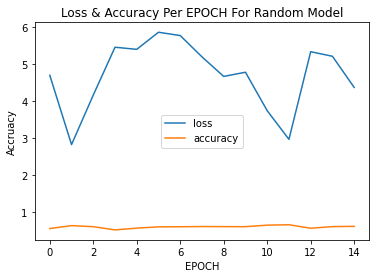

In [86]:
# Construct the RandomSearch tuner using the hypermodel class created
random_tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    seed=10, 
    project_name='keras_results')


# Search for the best parameters of the neural network using the contructed Hypberband tuner
random_tuner.search(train_data, train_labels,
             epochs=10,
             validation_data=(dev_data, dev_labels))

# Get the best hyperparameters from the search
random_params = random_tuner.get_best_hyperparameters()[0]

# Build the model using the best hyperparameters
random_model = random_tuner.hypermodel.build(params)

# Train the best fitting model
random_model.fit(train_data, train_labels, epochs=15)

# Check the accuracy plots
random_accuracy_df = pd.DataFrame(random_model.history.history)

random_accuracy_df[['loss', 'accuracy']].plot()
plt.title('Loss & Accuracy Per EPOCH For Random Model')
plt.xlabel('EPOCH')
plt.ylabel('Accruacy')
plt.show()